# Graph net for link prediction

Question: does including the neighborhood provide a benefit over the pairwise classification?

In [1]:
import numpy as np
import torch
import sys

import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR

from torch.utils.data import random_split
from torch_geometric.loader import DataLoader

import torch_geometric.utils as geou

import torch_geometric.nn as gnn

from reco.model import EdgeConvBlock, DynamicEdgeConvBlock

from reco.training import precision_recall_curve, roc_auc
from reco.loss import QualityFocalLoss
from reco.datasetPU import TracksterGraph


ds_name = "CloseByTwoPion"

data_root = "data"
raw_dir = f"/Users/ecuba/data/{ds_name}"

# data_root = "/mnt/ceph/users/ecuba/processed"
# raw_dir = f"/mnt/ceph/users/ecuba/{ds_name}"

In [2]:
# CUDA Setup
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
ds = TracksterGraph(
    ds_name,
    data_root,
    raw_dir,
    N_FILES=200,
    radius=100,
    bigT_e_th=10,
    link_prediction=True,
    pileup=False,
)
ds

TracksterGraph(graphs=19968, nodes=563041, radius=100, bigT_e_th=10, lp)

In [4]:
ds_size = len(ds)
test_set_size = ds_size // 10
train_set_size = ds_size - test_set_size
train_set, test_set = random_split(ds, [train_set_size, test_set_size])
print(f"Train graphs: {len(train_set)}, Test graphs: {len(test_set)}, total: {ds_size}")

train_dl = DataLoader(train_set, batch_size=8, shuffle=True, drop_last=True)
test_dl = DataLoader(test_set, batch_size=8, shuffle=True, drop_last=True)

Train graphs: 17972, Test graphs: 1996, total: 19968


In [5]:
class LinkPredictionNet(nn.Module):
    def __init__(self, input_dim, output_dim=1, dropout=0.1):
        super(LinkPredictionNet, self).__init__()
        self.norm = gnn.LayerNorm(input_dim)
        
        hdim1 = 32
        hdim2 = 64
        hdim_fc = 128

        self.edgeconv1 = DynamicEdgeConvBlock(input_dim, hdim1, k=7)
        self.edgeconv2 = DynamicEdgeConvBlock(hdim1, hdim2, k=7)
        
        # Edge features from node embeddings for classification        
        self.nodenetwork = nn.Sequential(
            nn.Linear(2 * hdim2, hdim_fc),
            nn.Sigmoid(),
            nn.Dropout(dropout),
            nn.Linear(hdim_fc, output_dim),
        )

    def forward(self, X, edge_index, batch=None):
        
        #(prepared_edges, _) = geou.add_self_loops(edge_index)  
        #undirected_index = geou.to_undirected(prepared_edges)

        H0 = X #self.norm(X, batch)
        H1 = self.edgeconv1(H0, batch=batch)
        H2 = self.edgeconv2(H1, batch=batch)
        
        H3 = H2

        src, dst = edge_index
        edges = torch.cat([H3[src], H3[dst]], dim=-1)
        return self.nodenetwork(edges).squeeze(-1)

In [6]:
def train_link_prediction(model, device, optimizer, loss_func, train_dl):
    train_loss = []
    model.train()

    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()

        seg_pred = model(data.x, data.edge_index, batch=data.batch)        
        loss = loss_func(seg_pred, data.y)
        
        loss.backward()
        
        optimizer.step()
        train_loss.append(loss.item())

    return np.mean(train_loss)

In [7]:
@torch.no_grad()
def test_link_prediction(model, device, loss_func, test_dl):
    test_loss = []
    model.eval()
    for data in test_dl:
        data = data.to(device)
        seg_pred = model(data.x, data.edge_index, data.batch)
        loss = loss_func(seg_pred, data.y)
        test_loss.append(loss.item())

    return np.mean(test_loss)

In [8]:
model = LinkPredictionNet(input_dim=ds.data.x.shape[1])
epochs = 51
model_path = f"models/LinkPredictionNet.PnetL.ns.{epochs}e-{ds_name}.r{ds.RADIUS}.e{ds.bigT_e_th}.f{ds.N_FILES}.pt"

In [9]:
%%script echo skipping
# alpha - percentage of negative edges
loss_func = nn.BCEWithLogitsLoss()

model = model.to(device)
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = CosineAnnealingLR(optimizer, epochs, eta_min=1e-5)

for epoch in range(epochs):

    train_loss = train_link_prediction(
        model,
        device,
        optimizer,
        loss_func,
        train_dl
    )
    
    scheduler.step()

    if epoch % 2 == 0:
        test_loss = test_link_prediction(model, device, loss_func, test_dl)
        print(
            f"Epoch {epoch}:\t train loss: {train_loss:.3f}\t validation loss: {test_loss:.3f}",
            file=sys.stderr
        )
        
torch.save(model.state_dict(), model_path)
print(model_path)

skipping


In [10]:
#%%script echo skipping
model.load_state_dict(torch.load(
    model_path,
    map_location=device
))
model = model.to(device)

0.9583077774291774


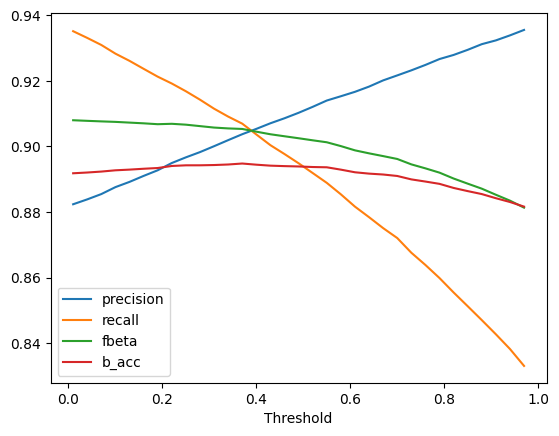

TP: 124526, TN: 92968, FP: 16602, FN: 8636
TH: 0.01 precision: 0.882 recall: 0.935 fbeta: 0.908 b_acc: 0.892


In [11]:
#%%script echo skipping
print(roc_auc(model, device, test_dl))
precision_recall_curve(model, device, test_dl, focus_metric="fbeta", beta=1, step=3, truth_threshold=0.5)

In [13]:
del ds

--> overfits: need more data!!

## Eval

In [12]:
import matplotlib.pyplot as plt
import numpy as np
from reco.data import get_event_data
from reco.evaluation import model_evaluation

file_name = f"{raw_dir}/new_ntuples_15101852_0.root"
cluster_data, trackster_data, simtrackster_data, assoc_data = get_event_data(file_name)

In [14]:
r_ranges = [5, 10, 20, 30, 50, 70, 100]
results = []

max_events = 20
clue3D_F = []
target_F = []
model_reco_F = []
for r in r_ranges:
    print(f" --- Radius threshold: {r} ---")
    result = model_evaluation(
        cluster_data,
        trackster_data,
        simtrackster_data,
        assoc_data,
        model,
        decision_th=0.5,
        radius=r,
        max_events=max_events,
        bigT_e_th=10,
        pileup=False,
        graph=True,
        link_prediction=True,
    )
    model_reco_F.append(np.sum(np.array(result["reco_to_sim"])[:,2]) / max_events)
    clue3D_F.append(np.sum(np.array(result["clue3d_to_sim"])[:,2]) / max_events)
    target_F.append(np.sum(np.array(result["target_to_sim"])[:,2]) / max_events)

 --- Radius threshold: 5 ---
Event 0:
	clue3d_to_sim:	P: 0.988 R: 0.229 F: 0.594
	target_to_sim:	P: 0.987 R: 0.442 F: 0.792
	reco_to_sim:	P: 0.987 R: 0.442 F: 0.792
	|S| = 2 |T| = 24 |R| = 24
Event 1:
	clue3d_to_sim:	P: 1.000 R: 0.283 F: 0.664
	target_to_sim:	P: 1.000 R: 0.348 F: 0.728
	reco_to_sim:	P: 1.000 R: 0.348 F: 0.728
	|S| = 2 |T| = 11 |R| = 11
Event 2:
	clue3d_to_sim:	P: 1.000 R: 0.396 F: 0.766
	target_to_sim:	P: 1.000 R: 0.402 F: 0.771
	reco_to_sim:	P: 1.000 R: 0.402 F: 0.771
	|S| = 2 |T| = 41 |R| = 41
Event 3:
	clue3d_to_sim:	P: 0.995 R: 0.383 F: 0.754
	target_to_sim:	P: 0.994 R: 0.648 F: 0.898
	reco_to_sim:	P: 0.994 R: 0.648 F: 0.898
	|S| = 2 |T| = 18 |R| = 18
Event 4:
	clue3d_to_sim:	P: 0.998 R: 0.250 F: 0.625
	target_to_sim:	P: 0.997 R: 0.602 F: 0.881
	reco_to_sim:	P: 0.997 R: 0.602 F: 0.881
	|S| = 2 |T| = 35 |R| = 35
Event 5:
	clue3d_to_sim:	P: 0.996 R: 0.551 F: 0.858
	target_to_sim:	P: 0.996 R: 0.673 F: 0.909
	reco_to_sim:	P: 0.996 R: 0.673 F: 0.909
	|S| = 2 |T| = 16 |R

In [15]:
print(clue3D_F)
print(target_F)
print(model_reco_F)

[0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464, 0.657833488850464]
[0.7825109551656922, 0.8437354538062112, 0.8827909550411878, 0.8949147404605471, 0.896723513091889, 0.8984433591070247, 0.8984433591070247]
[0.7806633551764323, 0.8415168841944893, 0.8799705030304544, 0.8912514787270778, 0.8933921037506163, 0.8939779159344413, 0.8887618163668993]


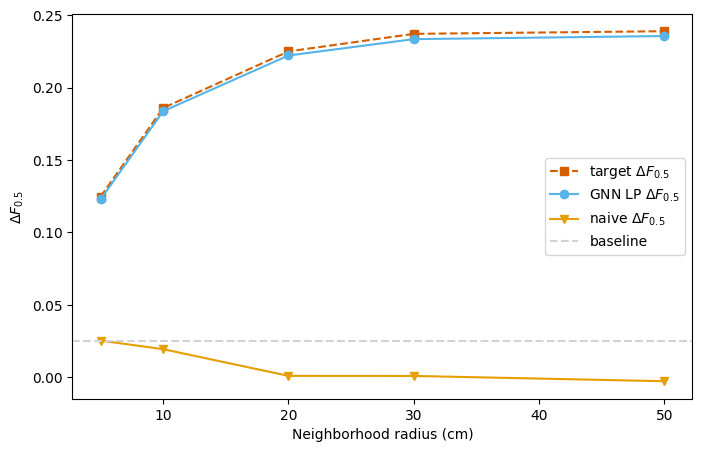

In [106]:
fig = plt.figure(figsize=(8, 5))

ax = fig.add_subplot(111)

ax.plot(r_ranges[:5], (np.array(target_F) - np.array(clue3D_F))[:5], '--s', label="target $\Delta F_{0.5}$", c="#D55E00")
ax.plot(r_ranges[:5], (np.array(model_reco_F) - np.array(clue3D_F))[:5], '-o', label="GNN LP $\Delta F_{0.5}$", c="#56B4E9")
ax.plot(r_ranges[:5], (np.array(naive_reco_F) - np.array(clue3D_F))[:5], '-v', label="naive $\Delta F_{0.5}$", c="#E69F00")

ax.axhline(max(np.array(naive_reco_F) - np.array(clue3D_F)), label="baseline", c="lightgray", linestyle="--")

ax.legend()
ax.set_xlabel("Neighborhood radius (cm)")
ax.set_ylabel("$\Delta F_{0.5}$")
# ax.set_ylim((-0.1, 0.1))

fig.savefig(f'export/{ds_name}-e10-graph-lp-to50-de-radius-plot.png', dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [105]:
print("Reco", max(np.array(model_reco_F) - np.array(clue3D_F)))
print("Naive", max(np.array(naive_reco_F) - np.array(clue3D_F)))
print("Target", max(np.array(target_F) - np.array(clue3D_F)))

Reco 0.23555861490015229
Naive 0.0252482447684228
Target 0.24060987025656067


## Setup comparison:

Pairwise:
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.689 F: 0.892
- mean reco_to_sim:	    P: 0.659 R: 0.699 F: 0.642

Graph (node-pred):
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.688 F: 0.892
- mean reco_to_sim:	    P: 0.659 R: 0.699 F: 0.642

Graph (link-pred):
- mean clue3d_to_sim:	P: 0.994 R: 0.301 F: 0.652
- mean target_to_sim:	P: 0.992 R: 0.689 F: 0.892
- mean reco_to_sim:	P: 0.915 R: 0.329 F: 0.637


## Results

Using alpha=balance seems to converge faster (100 epochs rather than 200)
- maybe just sticking to 0.25? (works just fine)

Hyperparams
- (64, 128, noskip), alpha=balance, roc_auc = 0.9733
- (64, 128, 256fc, noskip, 200e), alpha=1-balance, roc_auc = 0.9771
- (64, 128, 256fc, noskip, 200e), alpha=balance, roc_auc = 0.981
- (64, 128, 256fc, noskip, 100e), alpha=0.25, roc_auc = 0.9796